In [29]:
import requests 
from bs4 import BeautifulSoup
import pandas as pd

def scrape_nba_stats(year):
    url = f'https://www.basketball-reference.com/leagues/NBA_{year}_per_game.html'
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    table = soup.find('table', {'id': 'per_game_stats'})
    
    # Extract headers
    headers = [th.get_text() for th in table.find('thead').find_all('th')] #th mean table head
    headers = headers[1:]  # Remove the first 'Rank' column header
    
    # Extract rows
    rows = table.find('tbody').find_all('tr') #Tr means table row
    data = []
    
    for row in rows:
        if row.find('th', {'scope': 'row'}) is not None:
            player_data = [td.get_text() if td is not None else '' for td in row.find_all('td')]
            data.append(player_data)
    
    # Create DataFrame
    df = pd.DataFrame(data, columns=headers)
    
    return df

def combine_player_stats(df):
    # Convert numeric columns to appropriate types (this step is necessary because web scraping alone doesn't provide distinct data type)
    numeric_cols = ['Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
    
    main_positions = {'PG', 'SG', 'SF', 'PF', 'C'}
    df['Pos'] = df['Pos'].apply(lambda x: next((pos for pos in x.split('-') if pos in main_positions), 'Unknown'))

    # Group by player name
    aggregation_functions = {
        'Pos': 'first', 'Age': 'first', 'Tm': lambda x: ','.join(x), 'G': 'sum', 'GS': 'sum', 'MP': 'sum',
        'FG': 'sum', 'FGA': 'sum', '3P': 'sum', '3PA': 'sum', '2P': 'sum', '2PA': 'sum', 'FT': 'sum', 'FTA': 'sum',
        'ORB': 'sum', 'DRB': 'sum', 'TRB': 'sum', 'AST': 'sum', 'STL': 'sum', 'BLK': 'sum', 'TOV': 'sum', 'PF': 'sum', 'PTS': 'sum'
    }
    
    combined_df = df.groupby('Player').agg(aggregation_functions).reset_index()

    # Filter out players with more than 82 games played (some players may exceed 82 games when combining regular season and playoff games. To get the actual season games, I would need to access every player in the NBA and select the appropriate year, which is redundant)
    combined_df = combined_df[combined_df['G'] <= 82]

    # Calculate weighted percentages
    combined_df['FG%'] = combined_df['FG'] / combined_df['FGA']
    combined_df['3P%'] = combined_df['3P'] / combined_df['3PA']
    combined_df['2P%'] = combined_df['2P'] / combined_df['2PA']
    combined_df['eFG%'] = (combined_df['FG'] + 0.5 * combined_df['3P']) / combined_df['FGA']
    combined_df['FT%'] = combined_df['FT'] / combined_df['FTA']

    return combined_df

# Scrape the data
nba_data_2024 = scrape_nba_stats(2024)

# Combine player stats across teams
combined_nba_data_2024 = combine_player_stats(nba_data_2024)

print(combined_nba_data_2024.head())


          Player Pos  Age   Tm   G  GS    MP   FG  FGA   3P  ...  STL  BLK  \
0     A.J. Green  SG   24  MIL  56   0  11.0  1.5  3.5  1.2  ...  0.2  0.1   
1    A.J. Lawson  SG   23  DAL  42   0   7.4  1.3  2.9  0.3  ...  0.2  0.1   
2     AJ Griffin  SF   20  ATL  20   0   8.6  0.9  3.1  0.5  ...  0.1  0.1   
3   Aaron Gordon  PF   28  DEN  73  73  31.5  5.5  9.8  0.5  ...  0.8  0.6   
4  Aaron Holiday  PG   27  HOU  78   1  16.3  2.4  5.3  1.1  ...  0.5  0.1   

   TOV   PF   PTS       FG%       3P%       2P%      eFG%       FT%  
0  0.2  0.9   4.5  0.428571  0.400000  0.600000  0.600000  1.000000  
1  0.3  0.5   3.2  0.448276  0.250000  0.588235  0.500000  0.800000  
2  0.4  0.3   2.4  0.290323  0.250000  0.333333  0.370968  1.000000  
3  1.4  1.9  13.9  0.561224  0.263158  0.620253  0.586735  0.648649  
4  0.7  1.6   6.6  0.452830  0.392857  0.500000  0.556604  0.875000  

[5 rows x 29 columns]


1. What is the average number of points scored per game for each of the five player positions?

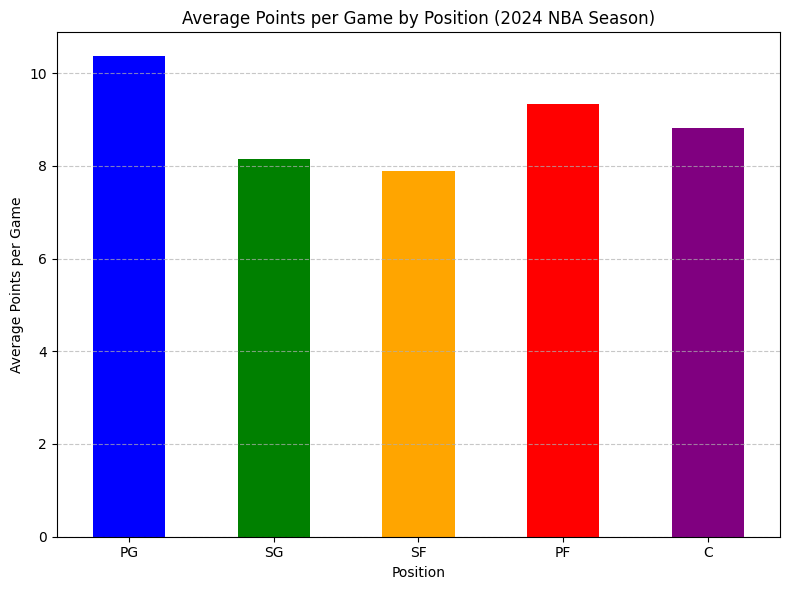

Pos
PG    10.361053
SG     8.152000
SF     7.887611
PF     9.335294
C      8.814444
Name: PTS, dtype: float64


In [6]:
import matplotlib.pyplot as plt

# Group by position and calculate average points per game
avg_points_by_position = combined_nba_data_2024.groupby('Pos')['PTS'].mean()

position_colors = {
    'PG': 'blue',
    'SG': 'green',
    'SF': 'orange',
    'PF': 'red',
    'C': 'purple'
}

desired_order = ['PG', 'SG', 'SF', 'PF', 'C']

avg_points_by_position = avg_points_by_position.reindex(desired_order)

colors = [position_colors[pos] for pos in avg_points_by_position.index]

# Plotting
plt.figure(figsize=(8, 6))

avg_points_by_position.plot(kind='bar', color=colors)
plt.title('Average Points per Game by Position (2024 NBA Season)')
plt.xlabel('Position')
plt.ylabel('Average Points per Game')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(avg_points_by_position)

Is the variance in points scored per game different between guards, forwards, and centers?

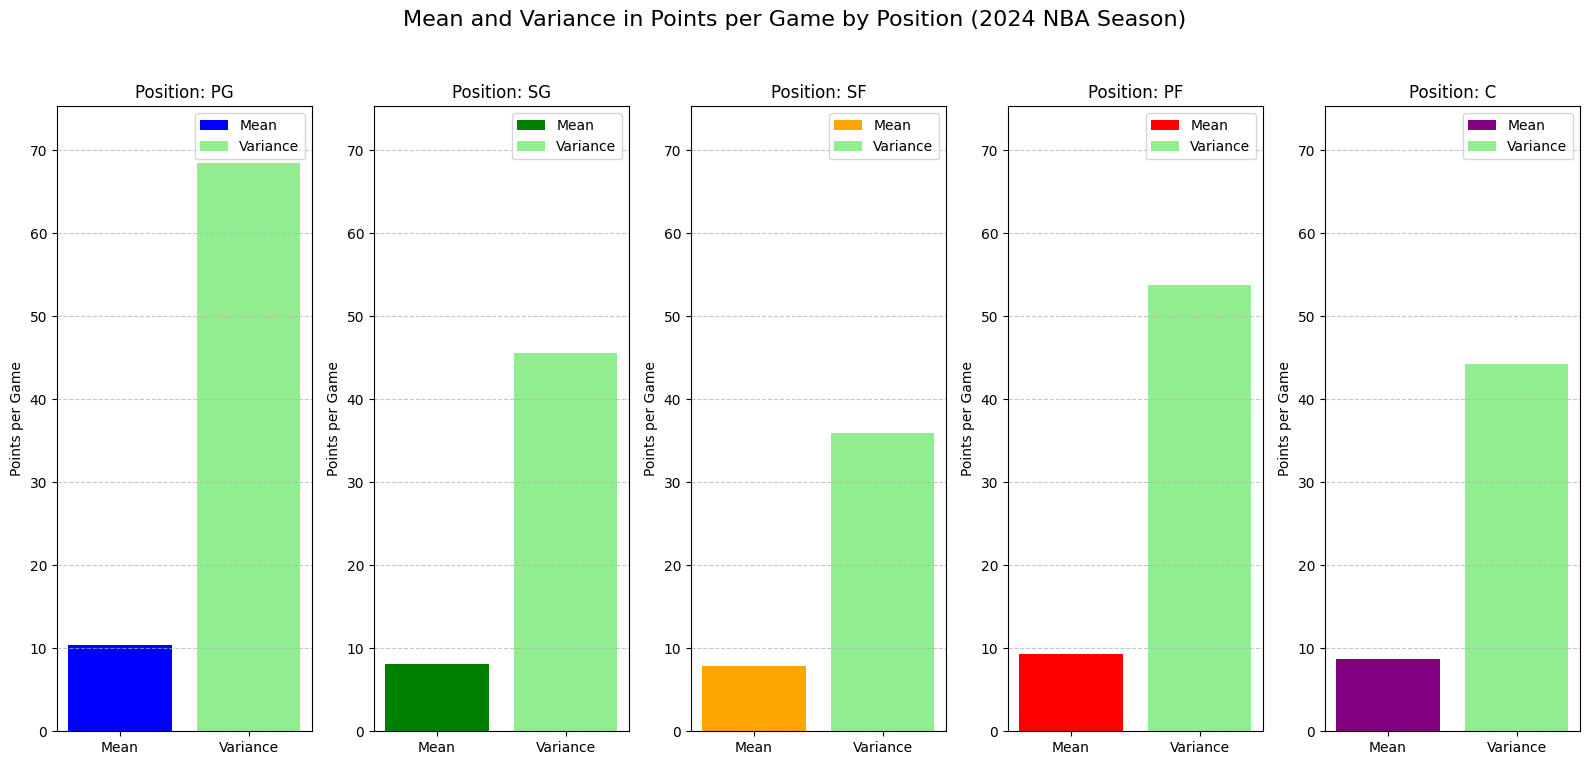

Pos
PG    68.442086
SG    45.588806
SF    35.909546
PF    53.809831
C     44.228095
Name: PTS, dtype: float64


In [26]:
import matplotlib.pyplot as plt

position_colors = {
    'PG': 'blue',
    'SG': 'green',
    'SF': 'orange',
    'PF': 'red',
    'C': 'purple'
}

desired_order = ['PG', 'SG', 'SF', 'PF', 'C']

# Calculate mean points per game by position
mean_points_by_position = combined_nba_data_2024.groupby('Pos')['PTS'].mean()
mean_points_by_position = mean_points_by_position.reindex(desired_order)

# Calculate variance in points per game by position
variance_points_by_position = combined_nba_data_2024.groupby('Pos')['PTS'].var()
variance_points_by_position = variance_points_by_position.reindex(desired_order)

# Determine the max value for y-axis limit
max_y = max(mean_points_by_position.max(), variance_points_by_position.max()) * 1.1

# Plotting each position separately
positions = mean_points_by_position.index
colors = [position_colors[pos] for pos in positions]

plt.figure(figsize=(16, 8))

for i, pos in enumerate(positions):
    plt.subplot(1, len(positions), i+1)
    
    # Plot mean
    plt.bar('Mean', mean_points_by_position[pos], color=colors[i], label='Mean')
    
    # Plot variance
    plt.bar('Variance', variance_points_by_position[pos], color='lightgreen', label='Variance')
    
    plt.title(f'Position: {pos}')
    plt.ylabel('Points per Game')
    plt.xticks(rotation=0)
    plt.ylim(0, max_y)  # Set the y-axis limits for all subplots
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.suptitle('Mean and Variance in Points per Game by Position (2024 NBA Season)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print(variance_points_by_position)

3. Is the average number of rebounds per game the same across the five player positions?

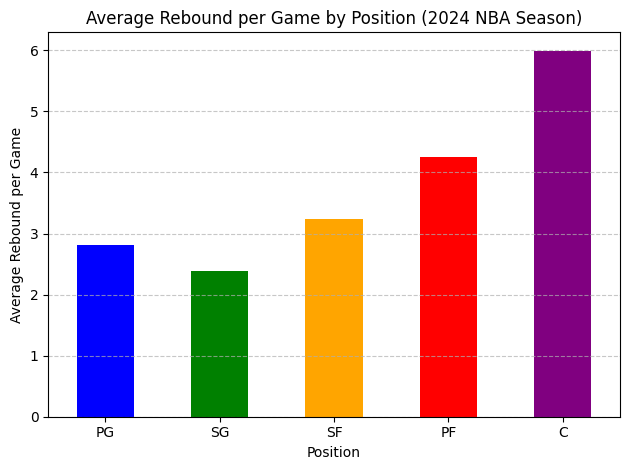

Pos
PG    2.817895
SG    2.381600
SF    3.235398
PF    4.248039
C     5.994444
Name: TRB, dtype: float64


In [7]:
import matplotlib.pyplot as plt
position_colors = {
    'PG': 'blue',
    'SG': 'green',
    'SF': 'orange',
    'PF': 'red',
    'C': 'purple'
}

desired_order = ['PG', 'SG', 'SF', 'PF', 'C']

# Calculate mean points per game by position
mean_total_rebound_by_position = combined_nba_data_2024.groupby('Pos')['TRB'].mean()
mean_total_rebound_by_position = mean_total_rebound_by_position.reindex(desired_order)
colors = [position_colors[pos] for pos in mean_total_rebound_by_position.index]

mean_total_rebound_by_position.plot(kind='bar', color=colors)
plt.title('Average Rebound per Game by Position (2024 NBA Season)')
plt.xlabel('Position')
plt.ylabel('Average Rebound per Game')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(mean_total_rebound_by_position)

4. Which position has the highest average assists per game among the five positions?

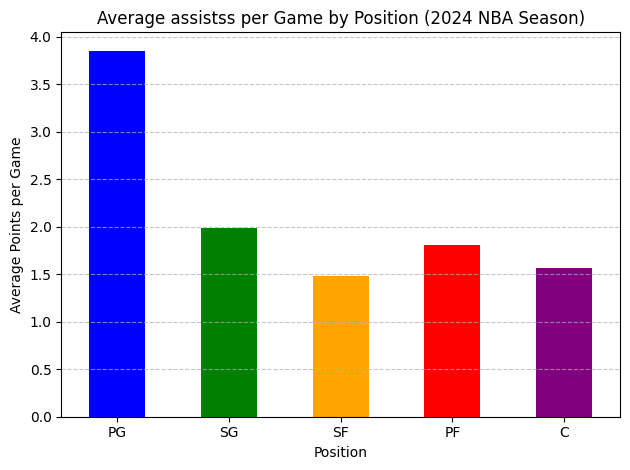

Pos
PG    3.853684
SG    1.988800
SF    1.478761
PF    1.808824
C     1.566667
Name: AST, dtype: float64


In [8]:
import matplotlib.pyplot as plt

position_colors = {
    'PG': 'blue',
    'SG': 'green',
    'SF': 'orange',
    'PF': 'red',
    'C': 'purple'
}

desired_order = ['PG', 'SG', 'SF', 'PF', 'C']

# Calculate mean points per game by position
mean_assists_by_position = combined_nba_data_2024.groupby('Pos')['AST'].mean()
mean_assists_by_position = mean_assists_by_position.reindex(desired_order)
colors = [position_colors[pos] for pos in mean_assists_by_position.index]

mean_assists_by_position.plot(kind='bar', color=colors)
plt.title('Average assistss per Game by Position (2024 NBA Season)')
plt.xlabel('Position')
plt.ylabel('Average Points per Game')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(mean_assists_by_position)

5. Which of the five positions commits fouls most frequently?

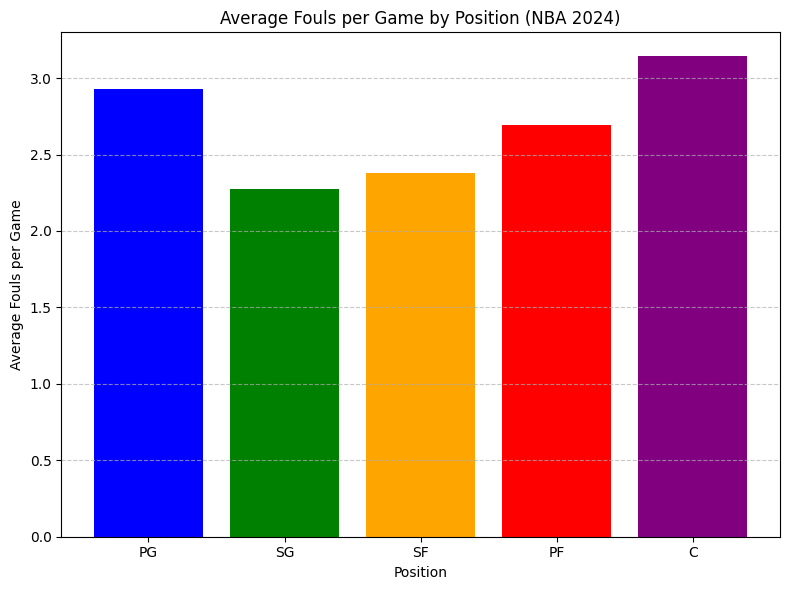

Average Fouls per Game by Position:
Pos
PG    2.926316
SG    2.272000
SF    2.382301
PF    2.692157
C     3.142222
Name: Fouls, dtype: float64


In [8]:
import matplotlib.pyplot as plt
position_colors = {
    'PG': 'blue',
    'SG': 'green',
    'SF': 'orange',
    'PF': 'red',
    'C': 'purple'
}

desired_order = ['PG', 'SG', 'SF', 'PF', 'C']

# Calculate total fouls per game by position
combined_nba_data_2024['Fouls'] = combined_nba_data_2024['PF'] + combined_nba_data_2024['TOV']  # Combined fouls

# Calculate average fouls per game by position
avg_fouls_by_position = combined_nba_data_2024.groupby('Pos')['Fouls'].mean().sort_values(ascending=False)
avg_fouls_by_position = avg_fouls_by_position.reindex(desired_order)

colors = [position_colors[pos] for pos in avg_fouls_by_position.index]

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(positions, avg_fouls_by_position, color=colors)
plt.title('Average Fouls per Game by Position (NBA 2024)')
plt.xlabel('Position')
plt.ylabel('Average Fouls per Game')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Print average fouls per game by position
print("Average Fouls per Game by Position:")
print(avg_fouls_by_position)


6. Is the average number of steal per game the same across the five player positions?

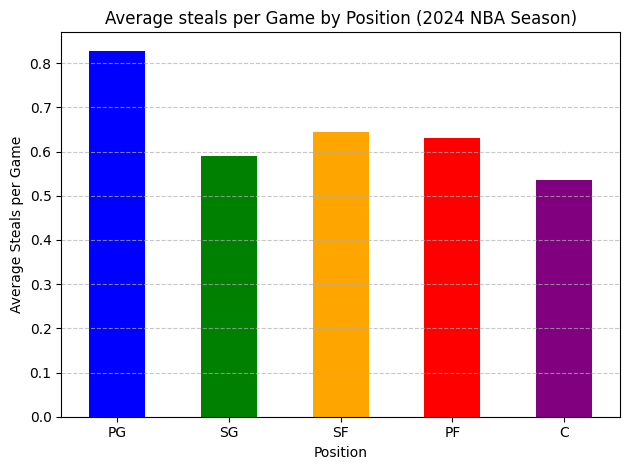

Pos
PG    0.828421
SG    0.589600
SF    0.644248
PF    0.630392
C     0.535556
Name: STL, dtype: float64


In [9]:
import matplotlib.pyplot as plt
position_colors = {
    'PG': 'blue',
    'SG': 'green',
    'SF': 'orange',
    'PF': 'red',
    'C': 'purple'
}

desired_order = ['PG', 'SG', 'SF', 'PF', 'C']

# Calculate mean points per game by position
mean_total_steal_by_position = combined_nba_data_2024.groupby('Pos')['STL'].mean()
mean_total_steal_by_position = mean_total_steal_by_position.reindex(desired_order)
colors = [position_colors[pos] for pos in mean_total_steal_by_position.index]

mean_total_steal_by_position.plot(kind='bar', color=colors)
plt.title('Average steals per Game by Position (2024 NBA Season)')
plt.xlabel('Position')
plt.ylabel('Average Steals per Game')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(mean_total_steal_by_position)

7. Is the average number of blocks per game the same across the five player positions?

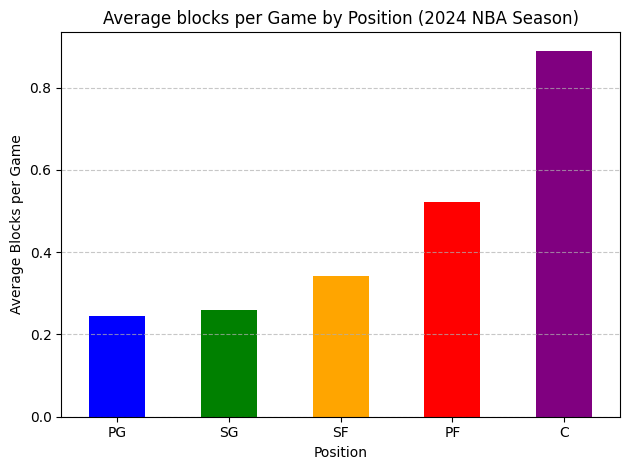

Pos
PG    0.245263
SG    0.258400
SF    0.341593
PF    0.522549
C     0.890000
Name: BLK, dtype: float64


In [10]:
import matplotlib.pyplot as plt
position_colors = {
    'PG': 'blue',
    'SG': 'green',
    'SF': 'orange',
    'PF': 'red',
    'C': 'purple'
}

desired_order = ['PG', 'SG', 'SF', 'PF', 'C']

# Calculate mean points per game by position
mean_total_block_by_position = combined_nba_data_2024.groupby('Pos')['BLK'].mean()
mean_total_block_by_position = mean_total_block_by_position.reindex(desired_order)
colors = [position_colors[pos] for pos in mean_total_block_by_position.index]

mean_total_block_by_position.plot(kind='bar', color=colors)
plt.title('Average blocks per Game by Position (2024 NBA Season)')
plt.xlabel('Position')
plt.ylabel('Average Blocks per Game')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(mean_total_block_by_position)

1. What is the distribution of positions in the NBA

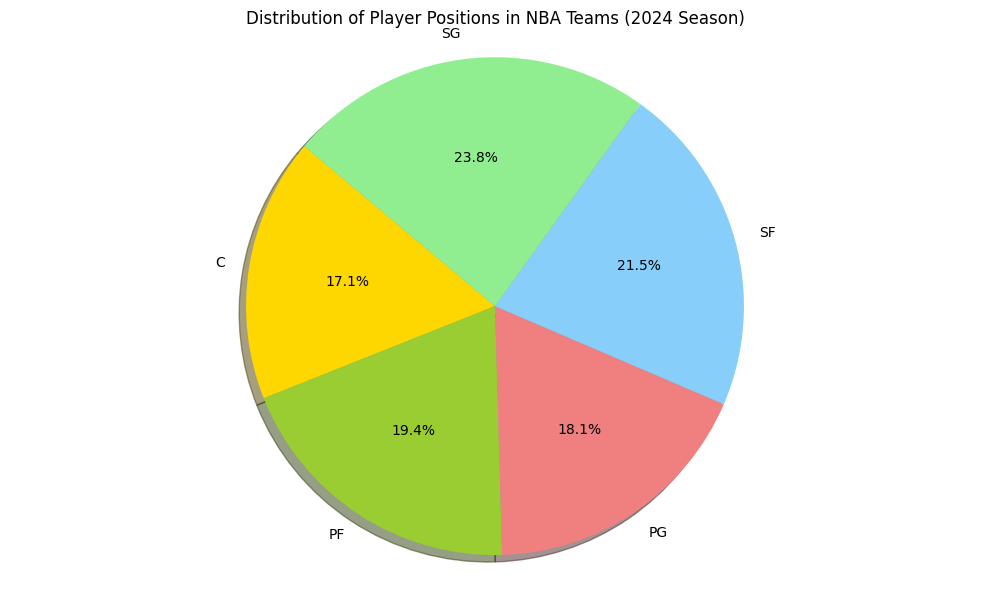

In [12]:
import matplotlib.pyplot as plt
def position_distribution(df):
    # Group by team and position, then count players
    position_counts = df.groupby(['Tm', 'Pos']).size().reset_index(name='Count')
    return position_counts

def plot_position_distribution(position_counts):
    # Sum up counts by position
    position_sum = position_counts.groupby('Pos')['Count'].sum()

    # Plotting Pie Chart
    plt.figure(figsize=(10, 6))
    labels = position_sum.index
    sizes = position_sum.values
    colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen']

    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
    plt.title('Distribution of Player Positions in NBA Teams (2024 Season)')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.tight_layout()

    plt.show()


# Calculate position distribution
position_counts = position_distribution(combined_nba_data_2024)

# Plot position distribution
plot_position_distribution(position_counts)


2. What is the distribution point for each position in NBA ?

<Figure size 1200x800 with 0 Axes>

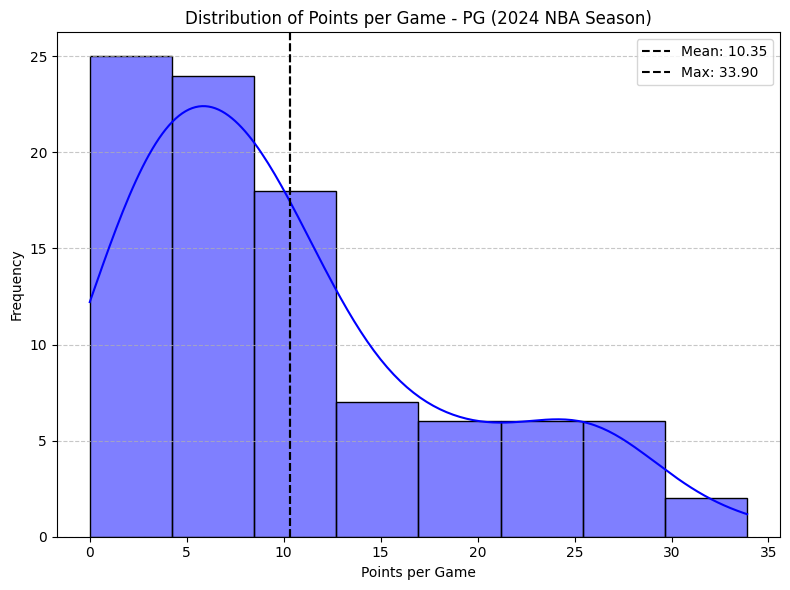

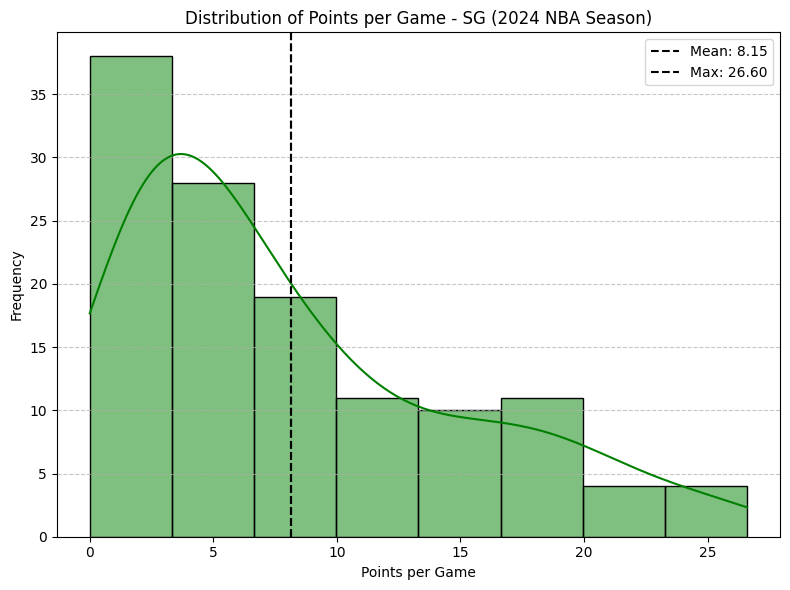

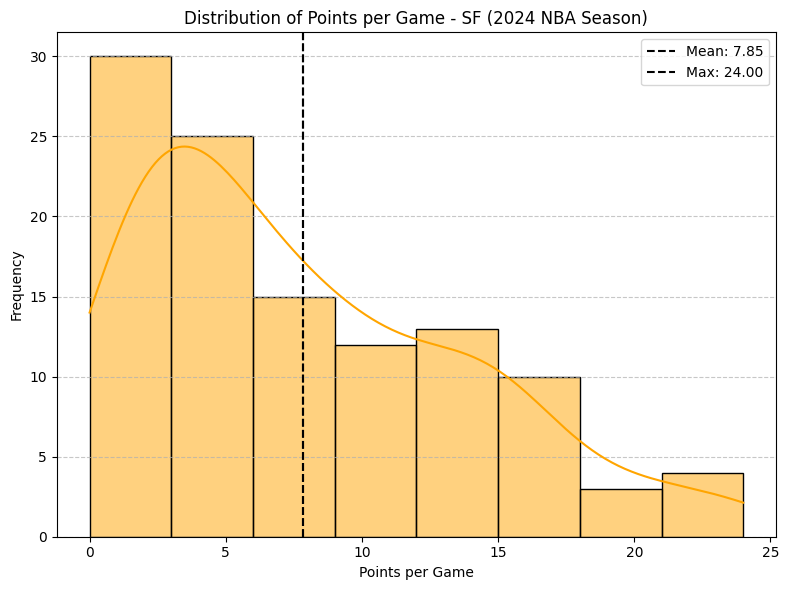

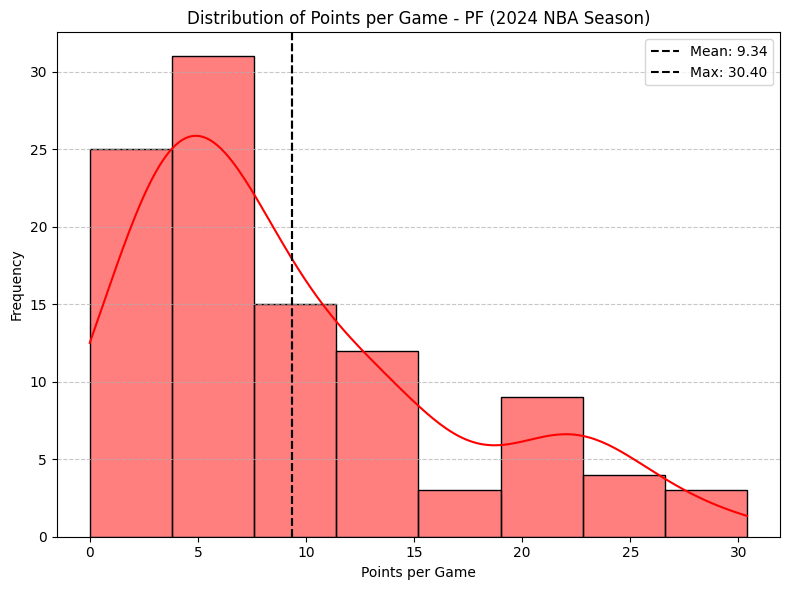

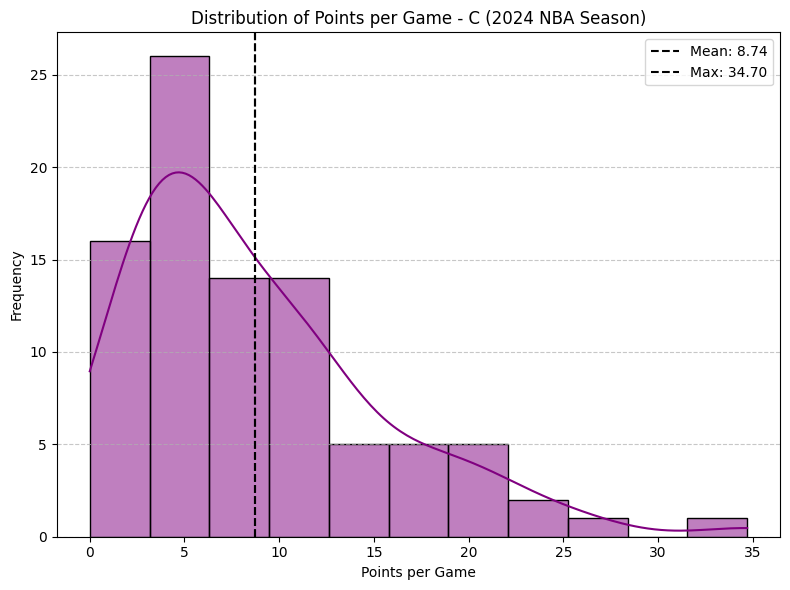

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

position_colors = {
    'PG': 'blue',
    'SG': 'green',
    'SF': 'orange',
    'PF': 'red',
    'C': 'purple'
}

desired_order = ['PG', 'SG', 'SF', 'PF', 'C']
# Calculate max points per game by position
max_points_by_position = combined_nba_data_2024.groupby('Pos')['PTS'].max()
max_points_by_position = max_points_by_position.reindex(desired_order)
# Calculate mean points per game by position
mean_points_by_position = combined_nba_data_2024.groupby('Pos')['PTS'].mean()
mean_points_by_position = mean_points_by_position.reindex(desired_order)
# Plotting each position separately
positions = mean_points_by_position.index
colors = ['blue', 'green', 'orange', 'red', 'purple']

plt.figure(figsize=(12, 8))

for i, pos in enumerate(positions):
    # Filter data for the current position
    data_pos = combined_nba_data_2024[combined_nba_data_2024['Pos'] == pos]['PTS']
    
    # Create a new figure for each position
    plt.figure(figsize=(8, 6))
    
    # Plot distribution
    sns.histplot(data_pos, kde=True, color=colors[i])
    plt.title(f'Distribution of Points per Game - {pos} (2024 NBA Season)')
    plt.xlabel('Points per Game')
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Plot mean
    plt.axvline(mean_points_by_position[pos], color='k', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean_points_by_position[pos]:.2f}')
    plt.axvline(mean_points_by_position[pos], color='k', linestyle='dashed', linewidth=1.5, label=f'Max: {max_points_by_position[pos]:.2f}')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


3. How likely is a player to be a point guard if they have the highest points on the team?

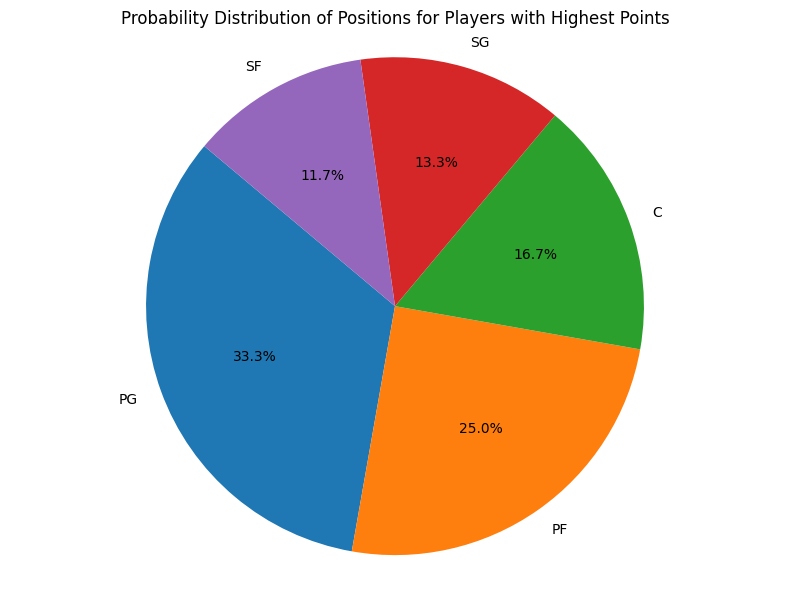

Probabilities:
PG: 0.33
PF: 0.25
C: 0.17
SG: 0.13
SF: 0.12


In [30]:
import matplotlib.pyplot as plt

# Filter data for players with highest points in their team
highest_points_players = combined_nba_data_2024[combined_nba_data_2024['PTS'] == combined_nba_data_2024.groupby('Tm')['PTS'].transform('max')]

# Count distribution of positions among players with highest points
position_counts = highest_points_players['Pos'].value_counts()

# Calculate probabilities
total_players = position_counts.sum()
probabilities = position_counts / total_players

# Plotting pie chart for position probabilities
fig, ax = plt.subplots(figsize=(8, 6))
ax.pie(probabilities, labels=probabilities.index, autopct='%1.1f%%', startangle=140, colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
ax.set_title('Probability Distribution of Positions for Players with Highest Points')
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

plt.tight_layout()
plt.show()

# Display probabilities
print("Probabilities:")
for pos, prob in probabilities.items():
    print(f"{pos}: {prob:.2f}")




4. How likely is a player to be a point guard if they have the blocks on the team?

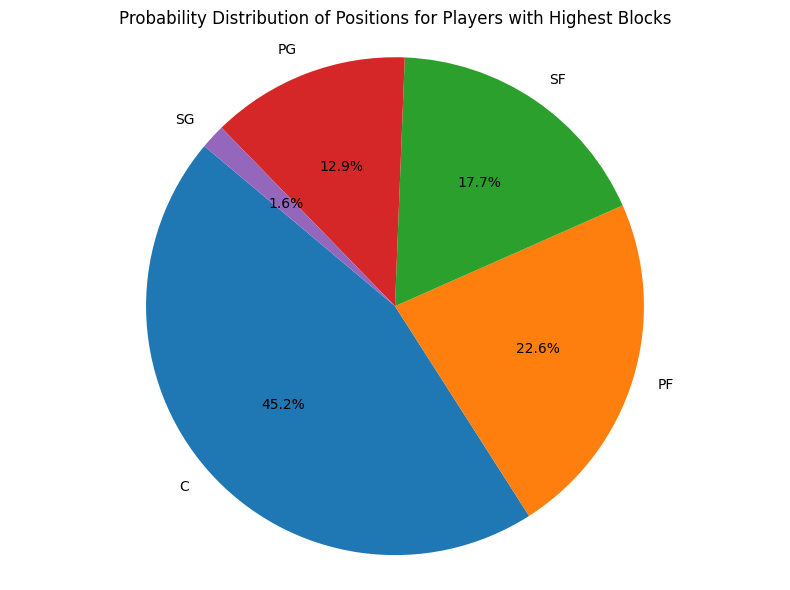

Probabilities:
C: 0.45
PF: 0.23
SF: 0.18
PG: 0.13
SG: 0.02


In [34]:
import matplotlib.pyplot as plt

# Filter data for players with highest blocks in their team
highest_blocks_players = combined_nba_data_2024[combined_nba_data_2024['BLK'] == combined_nba_data_2024.groupby('Tm')['BLK'].transform('max')]

# Count distribution of positions among players with highest points
position_counts = highest_blocks_players['Pos'].value_counts()

# Calculate probabilities
total_players = position_counts.sum()
probabilities = position_counts / total_players

# Plotting pie chart for position probabilities
fig, ax = plt.subplots(figsize=(8, 6))
ax.pie(probabilities, labels=probabilities.index, autopct='%1.1f%%', startangle=140, colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
ax.set_title('Probability Distribution of Positions for Players with Highest Blocks')
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

plt.tight_layout()
plt.show()

# Display probabilities
print("Probabilities:")
for pos, prob in probabilities.items():
    print(f"{pos}: {prob:.2f}")

5. How likely is a player to be a point guard if they have the steals on the team?

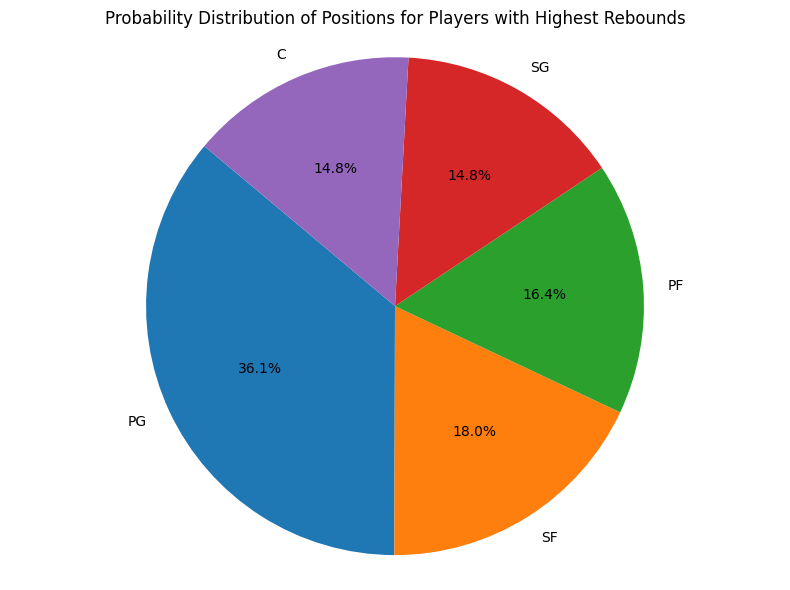

Probabilities:
PG: 0.36
SF: 0.18
PF: 0.16
SG: 0.15
C: 0.15


In [33]:
import matplotlib.pyplot as plt

# Filter data for players with highest steals in their team
highest_steals_players = combined_nba_data_2024[combined_nba_data_2024['STL'] == combined_nba_data_2024.groupby('Tm')['STL'].transform('max')]

# Count distribution of positions among players with highest points
position_counts = highest_steals_players['Pos'].value_counts()

# Calculate probabilities
total_players = position_counts.sum()
probabilities = position_counts / total_players

# Plotting pie chart for position probabilities
fig, ax = plt.subplots(figsize=(8, 6))
ax.pie(probabilities, labels=probabilities.index, autopct='%1.1f%%', startangle=140, colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
ax.set_title('Probability Distribution of Positions for Players with Highest Steals')
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

plt.tight_layout()
plt.show()

# Display probabilities
print("Probabilities:")
for pos, prob in probabilities.items():
    print(f"{pos}: {prob:.2f}")

6. How likely is a player to be a point guard if they have the rebounds on the team?

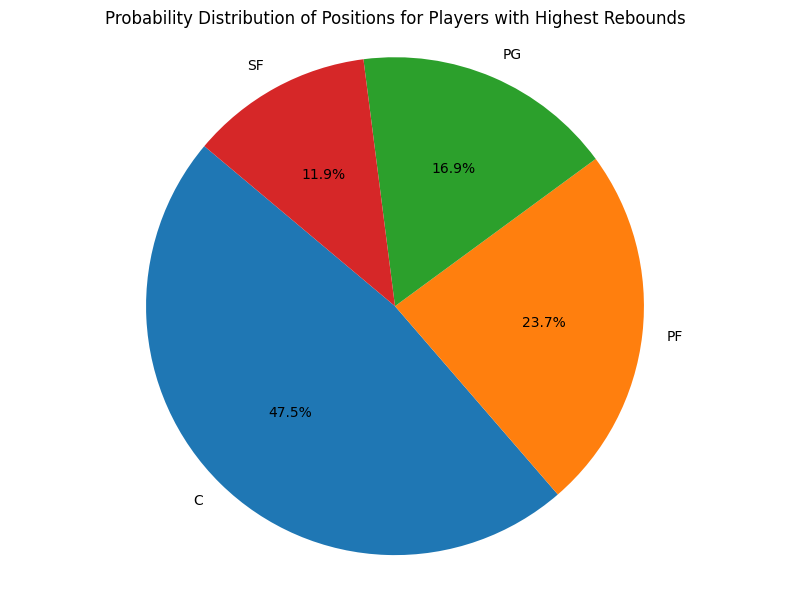

Probabilities:
C: 0.47
PF: 0.24
PG: 0.17
SF: 0.12


In [32]:
import matplotlib.pyplot as plt

# Filter data for players with highest rebounds in their team
highest_rebounds_players = combined_nba_data_2024[combined_nba_data_2024['TRB'] == combined_nba_data_2024.groupby('Tm')['TRB'].transform('max')]

# Count distribution of positions among players with highest points
position_counts = highest_rebounds_players['Pos'].value_counts()

# Calculate probabilities
total_players = position_counts.sum()
probabilities = position_counts / total_players

# Plotting pie chart for position probabilities
fig, ax = plt.subplots(figsize=(8, 6))
ax.pie(probabilities, labels=probabilities.index, autopct='%1.1f%%', startangle=140, colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
ax.set_title('Probability Distribution of Positions for Players with Highest Rebounds')
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

plt.tight_layout()
plt.show()

# Display probabilities
print("Probabilities:")
for pos, prob in probabilities.items():
    print(f"{pos}: {prob:.2f}")

7. . How likely is a player to be a point guard if they have the highest asissts on the team?

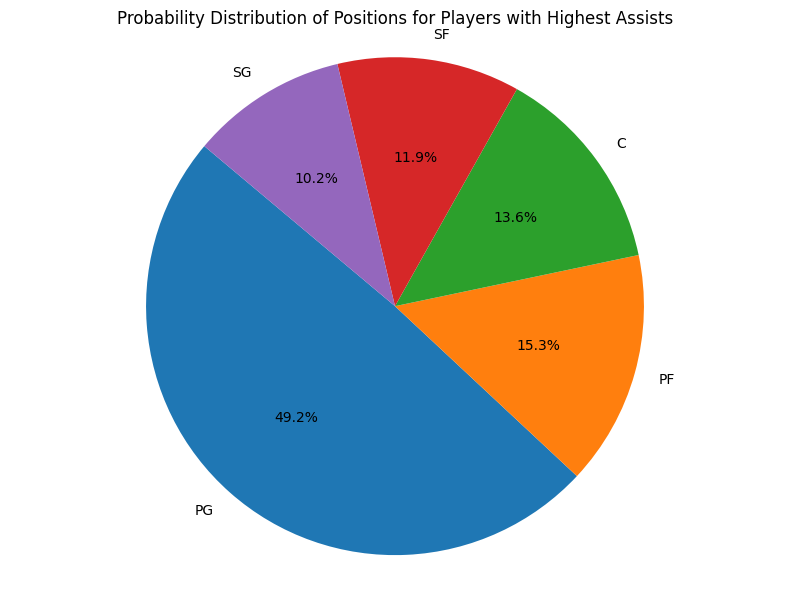

Probabilities:
PG: 0.49
PF: 0.15
C: 0.14
SF: 0.12
SG: 0.10


In [40]:
import matplotlib.pyplot as plt

# Filter data for players with highest assists in their team
highest_assists_players = combined_nba_data_2024[combined_nba_data_2024['AST'] == combined_nba_data_2024.groupby('Tm')['AST'].transform('max')]

# Count distribution of positions among players with highest points
position_counts = highest_assists_players['Pos'].value_counts()

# Calculate probabilities
total_players = position_counts.sum()
probabilities = position_counts / total_players

# Plotting pie chart for position probabilities
fig, ax = plt.subplots(figsize=(8, 6))
ax.pie(probabilities, labels=probabilities.index, autopct='%1.1f%%', startangle=140, colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
ax.set_title('Probability Distribution of Positions for Players with Highest Assists')
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

plt.tight_layout()
plt.show()

# Display probabilities
print("Probabilities:")
for pos, prob in probabilities.items():
    print(f"{pos}: {prob:.2f}")


8.. How likely is a player to be a center if they have the highest rebound on the team?

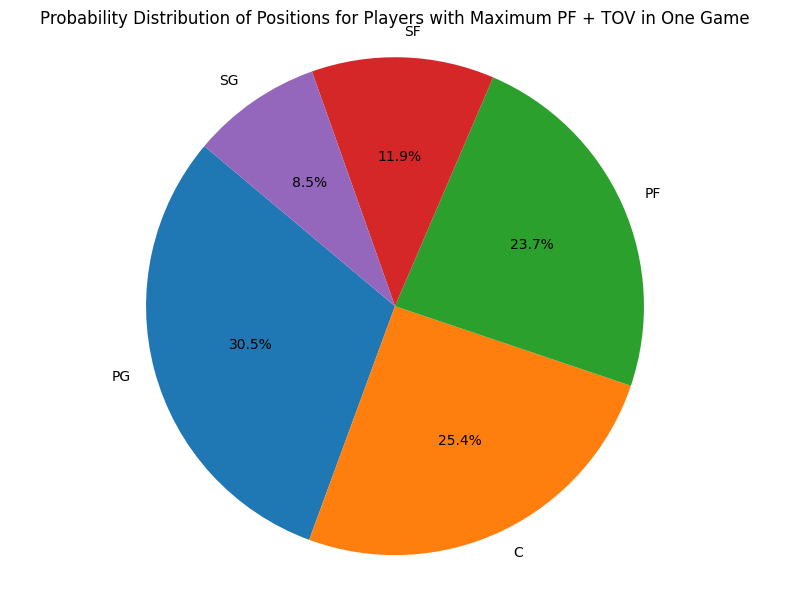

Probabilities:
PG: 0.31
C: 0.25
PF: 0.24
SF: 0.12
SG: 0.08


In [28]:
import matplotlib.pyplot as plt

# Calculate combined PF and TOV for each player
combined_nba_data_2024['PF_TOV'] = combined_nba_data_2024['PF'] + combined_nba_data_2024['TOV']

# Identify players with maximum combined PF_TOV in their team
max_pf_tov_players = combined_nba_data_2024[combined_nba_data_2024['PF_TOV'] == combined_nba_data_2024.groupby('Tm')['PF_TOV'].transform('max')]

# Count distribution of positions among players with maximum PF_TOV
position_counts = max_pf_tov_players['Pos'].value_counts()

# Calculate probabilities
total_players = position_counts.sum()
probabilities = position_counts / total_players

# Plotting pie chart for position probabilities
fig, ax = plt.subplots(figsize=(8, 6))
ax.pie(probabilities, labels=probabilities.index, autopct='%1.1f%%', startangle=140, colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
ax.set_title('Probability Distribution of Positions for Players with Maximum combined fouls in One Game')
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

plt.tight_layout()
plt.show()

# Display probabilities
print("Probabilities:")
for pos, prob in probabilities.items():
    print(f"{pos}: {prob:.2f}")


1. Find Covariance and Corellation between Height, Points and Age

In [13]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

def scrape_nba_stats(year):
    url = f'https://www.basketball-reference.com/leagues/NBA_{year}_per_game.html'
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    table = soup.find('table', {'id': 'per_game_stats'})
    
    # Extract headers
    headers = [th.get_text() for th in table.find('thead').find_all('th')]
    headers = headers[1:]  # Remove the first 'Rank' column header
    
    # Extract rows
    rows = table.find('tbody').find_all('tr')
    data = []
    
    for row in rows:
        if row.find('th', {'scope': 'row'}) is not None:
            player_data = [td.get_text() if td is not None else '' for td in row.find_all('td')]
            data.append(player_data)
    
    # Create DataFrame
    df = pd.DataFrame(data, columns=headers)
    
    return df

def combine_player_stats(df):
    # Convert numeric columns to appropriate types (this step is necessary because web scraping alone doesn't provide distinct data type)
    numeric_cols = ['Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
    
    # Group by player name
    aggregation_functions = {
        'Pos': 'first', 'Age': 'first', 'Tm': lambda x: ','.join(x), 'G': 'sum', 'GS': 'sum', 'MP': 'sum',
        'FG': 'sum', 'FGA': 'sum', '3P': 'sum', '3PA': 'sum', '2P': 'sum', '2PA': 'sum', 'FT': 'sum', 'FTA': 'sum',
        'ORB': 'sum', 'DRB': 'sum', 'TRB': 'sum', 'AST': 'sum', 'STL': 'sum', 'BLK': 'sum', 'TOV': 'sum', 'PF': 'sum', 'PTS': 'sum'
    }
    
    combined_df = df.groupby('Player').agg(aggregation_functions).reset_index()

    # Filter out players with more than 82 games played
    combined_df = combined_df[combined_df['G'] <= 82]

    # Calculate weighted percentages
    combined_df['FG%'] = combined_df['FG'] / combined_df['FGA']
    combined_df['3P%'] = combined_df['3P'] / combined_df['3PA']
    combined_df['2P%'] = combined_df['2P'] / combined_df['2PA']
    combined_df['eFG%'] = (combined_df['FG'] + 0.5 * combined_df['3P']) / combined_df['FGA']
    combined_df['FT%'] = combined_df['FT'] / combined_df['FTA']
    
    # Infer height category from positions (proxy for height)
    def position_to_height_category(position):
        if position in ['PG', 'SG']:
            return 'Guards (PG, SG)'
        elif position in ['SF', 'PF']:
            return 'Forwards (SF, PF)'
        elif position == 'C':
            return 'Centers (C)'
        else:
            return 'Other'
    
    combined_df['Height Category'] = combined_df['Pos'].apply(position_to_height_category)

    return combined_df

# Scrape the data
nba_data_2024 = scrape_nba_stats(2024)

# Combine player stats across teams
combined_nba_data_2024 = combine_player_stats(nba_data_2024)

# Convert categorical variables to numerical representations for Height Category
height_map = {'Guards (PG, SG)': 1, 'Forwards (SF, PF)': 2, 'Centers (C)': 3}
combined_nba_data_2024['Height Category Num'] = combined_nba_data_2024['Height Category'].map(height_map)

# Calculate covariance between Height Category Num and Age with respect to PTS
covariance_height_age_pts = combined_nba_data_2024[['Height Category Num', 'Age', 'PTS']].cov()
print("Covariance Matrix between Height Category Num, Age, and PTS:")
print(covariance_height_age_pts)

# Calculate correlation between Height Category Num and Age with respect to PTS
correlation_height_age_pts = combined_nba_data_2024[['Height Category Num', 'Age', 'PTS']].corr()
print("\nCorrelation Matrix between Height Category Num, Age, and PTS:")
print(correlation_height_age_pts)

Covariance Matrix between Height Category Num, Age, and PTS:
                     Height Category Num        Age        PTS
Height Category Num             0.529030   0.202499  -0.130436
Age                             0.202499  17.311145   4.051237
PTS                            -0.130436   4.051237  49.238054

Correlation Matrix between Height Category Num, Age, and PTS:
                     Height Category Num       Age       PTS
Height Category Num             1.000000  0.067006 -0.025514
Age                             0.067006  1.000000  0.138763
PTS                            -0.025514  0.138763  1.000000


Hypothesis Test using t test

In [22]:
import pandas as pd
from scipy import stats

nba_data_2024 = scrape_nba_stats(2024)

# Combine player stats across teams
combined_nba_data_2024 = combine_player_stats(nba_data_2024)

# Divide data into younger (age <= 25) and older (age > 25) categories for rebounds (TRB)
younger_rebounds = combined_nba_data_2024[combined_nba_data_2024['Age'] <= 25]['TRB']
older_rebounds = combined_nba_data_2024[combined_nba_data_2024['Age'] > 25]['TRB']

# Perform t-test
t_statistic, p_value = stats.ttest_ind(younger_rebounds, older_rebounds, equal_var=False)

# Print results
print(f"T-statistic: {t_statistic:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpret the results
alpha = 0.05  # significance level
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in rebounds between younger and older players.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in rebounds between younger and older players.")


T-statistic: -3.6723
P-value: 0.0003
Reject the null hypothesis: There is a significant difference in rebounds between younger and older players.


In [20]:
import pandas as pd
from scipy import stats

# Assuming combined_nba_data_2024 already contains Age and AST columns

# Example: Performing t-test between younger (age <= 25) and older (age > 25) players
younger_ast = combined_nba_data_2024[combined_nba_data_2024['Age'] <= 25]['AST']
older_ast = combined_nba_data_2024[combined_nba_data_2024['Age'] > 25]['AST']

# Perform t-test
t_statistic, p_value = stats.ttest_ind(younger_ast, older_ast, equal_var=False)

# Print results
print(f"T-statistic: {t_statistic:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpret the results
alpha = 0.05  # significance level
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in AST between younger and older players.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in AST between younger and older players.")


T-statistic: -3.8014
P-value: 0.0002
Reject the null hypothesis: There is a significant difference in AST between younger and older players.


In [21]:
import pandas as pd
from scipy import stats

nba_data_2024 = scrape_nba_stats(2024)

# Combine player stats across teams
combined_nba_data_2024 = combine_player_stats(nba_data_2024)

# Calculate 'stocks' (STL + BLK) and add to the dataframe
combined_nba_data_2024['Stocks'] = combined_nba_data_2024['STL'] + combined_nba_data_2024['BLK']

# Divide data into younger (age <= 25) and older (age > 25) categories for stocks
younger_stocks = combined_nba_data_2024[combined_nba_data_2024['Age'] <= 25]['Stocks']
older_stocks = combined_nba_data_2024[combined_nba_data_2024['Age'] > 25]['Stocks']

# Perform t-test
t_statistic, p_value = stats.ttest_ind(younger_stocks, older_stocks, equal_var=False)

# Print results
print(f"T-statistic: {t_statistic:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpret the results
alpha = 0.05  # significance level
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in stocks between younger and older players.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in stocks between younger and older players.")

T-statistic: -3.5198
P-value: 0.0005
Reject the null hypothesis: There is a significant difference in stocks between younger and older players.
